# Long-Short Term Memory (LSTM)

Las Long-Short Term Memories o LSTM son una herramienta de gran utilidad cuando se trabaja con RNNs, pues evitan el desvanecimiento del gradiente y conservan adecuadamente las dependencias a largo plazo. Realizaremos un ejemplo muy simple de una LSTM, aplicadno el algoritmo de backpropagation y de gradiente descendiente para un caso simple de datos secuenciales: etiquetado de lenguaje natural.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Dataset

Para preparar el dataset, al igual que en otros casos de lenguaje natural, convertimos las cadenas de caaracteres en índices numéricos para que la red pueda leerlos de manera apropiado. Definimos vocabularios para la entrada y la salidad, de tal forma que podamos transformar los datos de entrada en índices y recuperar las etiquetas de salida.

In [2]:
#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

#Entradas
inputs = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda', 'el perro come mucho',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come', 'yo juego mucho', 
          'el juego', 'un juego', 'yo juego un juego', 'el gato come mucho']

#Etiquetas de salida
outputs = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC', 'DA NC V Adv', 'DA NC V', 'DA NC V NC', 
           'DD NC V', 'DP V Adv', 'DA NC', 'DD NC', 'DP V DD NC', 'DA NC V Adv']

#Llamamos la funcion para crear el vocabulario
in_voc = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
x = list(text2numba(inputs,in_voc))

#Vocabulario de emisiones
out_voc = vocab()
#Se susituyen las emisiones por sus índices numéricos
y = list(text2numba(outputs,out_voc))

print(x)
print(y)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [0, 1, 2, 10], [3, 1, 2, 11], [0, 1, 2], [0, 12, 2, 11], [3, 12, 2], [13, 14, 10], [0, 14], [3, 14], [13, 14, 3, 14], [0, 12, 2, 10]]
[[0, 1, 2, 3, 1], [3, 1, 2], [0, 1, 2, 0, 1], [3, 1, 2, 1], [0, 1, 2, 4], [0, 1, 2], [0, 1, 2, 1], [3, 1, 2], [5, 2, 4], [0, 1], [3, 1], [5, 2, 3, 1], [0, 1, 2, 4]]


## Red recurrente con LSTMs

Recordemos que una LSTM se define a partir de 3 puertas $i$, $o$ y $f$ (escritura, lectura y olvido), dadas por las siguientes funciones:

$$i_t = \sigma(U^ix^{(t)} + V^ih^{(t-1)} + b^i)$$

$$o_t = \sigma(U^ox^{(t)} + V^oh^{(t-1)} + b^o)$$

$$f_t = \sigma(U^fx^{(t)} + V^fh^{(t-1)} + b^f)$$

Asimismo, se define el candidato a sombra de la forma:

$$\hat{c}_t = \tanh(U^cx^{(t)} + V^ch^{(t-1)} + b^c)$$

La sombra (la información que se mandará al siguiente estado) se define, entonces como:

$$c_t = f_t \odot c_{t-1} + i_t \odot \hat{c}_t$$

Y finalmente, la celda de salida para ese estado está dado por:

$$h_t = o_t \odot \tanh(c_t)$$

En general, la arquitectura de una capa con LSTM es la siguiente:

![LSTM](https://miro.medium.com/max/504/1*FPTmBD8GY9ZvkdsUBYXC9Q.png)

Ya que las puertas en el LSTM utilizan la función sigmoide, definimos ésta a continuación:

In [3]:
def sig(x):
    """Función sigmoide"""
    return 1./(1.+np.exp(-x))

### Inicialización de los parámetros

Ahora inicializamos los parámetros $\theta$. Estos parámetros son los siguientes:

1) Parámetros de la puerta de escritura: $V^i\in\mathbb{R}^{m\times m}$, $U^i\in\mathbb{R}^{m\times N}$ y $b^i\in\mathbb{R}^m$.

2) Parámetros de la puerta de olvido: $V^f\in\mathbb{R}^{m\times m}$, $U^f\in\mathbb{R}^{m\times N}$ y $b^f\in\mathbb{R}^m$.

3) Parámetros de la puerta de lectura: $V^o\in\mathbb{R}^{m\times m}$, $U^o\in\mathbb{R}^{m\times N}$ y $b^o\in\mathbb{R}^m$.

4) Parámetros de la sombra: $V^c\in\mathbb{R}^{m\times m}$, $U^c\in\mathbb{R}^{m\times N}$ y $b^c\in\mathbb{R}^m$.

5) Parámetros de la capa de salida: $W\in\mathbb{R}^{N\times m}$y $b\in\mathbb{R}^N$.

In [4]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = len(in_voc)
#El total de clases que arrojará
output_dim = len(out_voc)

#Dimensiones de los vectores-palabra
cell_dim = 3

#Celda de escritura
Vi = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Ui = np.random.randn(cell_dim, nn_input_dim) / np.sqrt(nn_input_dim)
bi = np.zeros(cell_dim)

#Celda de olvido
Vf = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uf = np.random.randn(cell_dim, nn_input_dim) / np.sqrt(nn_input_dim)
bf = np.zeros(cell_dim)

#Celda de lectura
Vo = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uo = np.random.randn(cell_dim, nn_input_dim) / np.sqrt(nn_input_dim)
bo = np.zeros(cell_dim)

#Celda de candidato
Vc = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uc = np.random.randn(cell_dim, nn_input_dim) / np.sqrt(nn_input_dim)
bc = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(nn_input_dim, cell_dim) / np.sqrt(cell_dim)
b = np.zeros(nn_input_dim)

### Entrenamiento de la red

Finalmente aplicamos el entrenamiento. En este caso, aplicamos el LSTM, y la capa de salida. Posteriormente aplicamos backpropagation sobre todos los parámetros para poder actualizarlos por medio del gradiente descendiente.

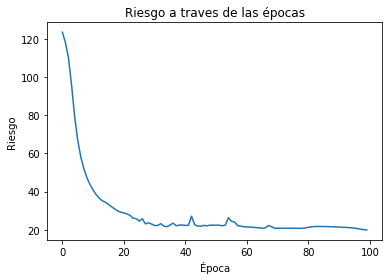

CPU times: user 906 ms, sys: 1.35 ms, total: 908 ms
Wall time: 906 ms


In [5]:
%%time
epochs = 100
lr = 0.1

risk = []
for t in range(epochs):
    epoch_risk = 0
    for (x_i, y_i) in zip(x, y):
        #Inicializacion de celdas
        h = np.zeros((len(x_i)+1,cell_dim))
        #Inicializacion de sombras
        c = np.zeros((len(x_i)+1,cell_dim))
        #Variable de cambio
        d_t = np.zeros(cell_dim)
        
        risk_x = 0
        for t, w in enumerate(x_i):
            #LSTM
            #Puerta de escritura
            i = sig(np.dot(Vi,h[t]) + Ui.T[w] + bi)
            #Puerta de olvido
            f = sig(np.dot(Vf,h[t]) + Uf.T[w] + bf)
            #Puerta de lectura
            o = sig(np.dot(Vo,h[t]) + Uo.T[w] + bo)
            
            #Candidato a sombra
            c_hat = np.tanh(np.dot(Vc,h[t]) + Uc.T[w] + bc)
            
            #Sombra en el estado actual
            c[t+1] = f*c[t] + i*c_hat
            
            #Celda en el estado actual
            h[t+1] = o*np.tanh(c[t+1])
            
            #FORWARD SALIDA
            #Softmax
            p = np.exp(np.dot(W,h[t+1])+b)
            phi = p/p.sum(0)
            
            risk_x += np.log(phi[y_i[t]])
            
            #BACK-PROP
            #Variable de salida
            d_out = phi
            d_out[y_i[t]] -= 1
            #GD salida
            dW = np.outer(d_out,h[t+1])
            W -=lr*dW
            
            #Variable de lectura
            d_o = np.dot(W.T,d_out)*np.tanh(c[t+1])*o*(1-o)
            #GD lectura Vo
            dVo = np.outer(d_o,h[t])
            Vo -= lr*dVo
            #GD lectura Uo
            Uo.T[w] -= d_o
            
            #Varible de estado (se usa en escritura, olvido y sombra)
            d_st = np.dot(W.T,d_out)*o*(1-np.tanh(c[t+1])**2) + d_t
                        
            #Variable de sombra
            d_c = d_st*i*(1-c_hat**2)
            #GD sombra Vc
            dVc = np.outer(d_c,h[t])
            Vc -= lr*dVc
            #GD sobra Uc
            Uc.T[w] -= d_c
            
            #Variable de escritura
            d_i = d_st*c_hat*i*(1-i)
            #GD escritura Vi
            dVi = np.outer(d_i,h[t])
            Vi -= lr*dVi
            #GD escritura Ui
            Ui.T[w] -= d_i
            
            #Variable de olvido
            d_f = d_st*c[t+1]*f*(1-f)
            #GD olvido Vf
            dVf = np.outer(d_f,h[t])
            Vf -= lr*dVf
            #GD olvido Uf
            Uf.T[w] -= d_f           
            
            #Nueva variable de cambio
            d_t = f*d_st
            
        epoch_risk -= risk_x
    risk.append(epoch_risk)
    
plt.plot(risk)
plt.title('Riesgo a traves de las épocas')
plt.xlabel('Época')
plt.ylabel('Riesgo')
plt.show()

### Etiquetado con LSTM

Para probar el etiquetado definimos una función que pueda tomar una cadena de lenguaje natural, aplique la red y regrese las etiquetas. 

In [6]:
tags = {i:w for w,i in out_voc.items()}
def tagger(sent, h = np.zeros(cell_dim), c=np.zeros(cell_dim)):
    """Función de etiquetado con LSTM"""
    sent = sent.split()
    prob_tot = np.zeros((len(sent), nn_input_dim))
    
    for t,w in enumerate(sent):
        i = sig(np.dot(Vi,h) + Ui.T[in_voc[w]] + bi)
        f = sig(np.dot(Vf,h) + Uf.T[in_voc[w]] + bf)
        o = sig(np.dot(Vo,h) + Uo.T[in_voc[w]] + bo)
        c_hat = np.tanh(np.dot(Vc,h) + Uc.T[in_voc[w]] + bc)
        c = f*c + i*c_hat
        h = o*np.tanh(c)
        p = np.exp(np.dot(W,h)+b)
        phi = p/p.sum(0)
        prob_tot[t] = phi
        
    sent_tags = [tags[j] for j in prob_tot.argmax(axis=1)]
    return ' '.join(sent_tags)

Podemos ver cómo se comporta en algunos datos de entrada.

In [7]:
etiqs = tagger('yo mucho juego el juego')

print(etiqs)

DP Adv V DD NC


### Visualización de las puertas y los estados ocultos

In [8]:
def get_cells(sent, h0 = np.zeros(cell_dim),c0=np.zeros(cell_dim)):
    """Función para recuperar las celdas del LSTM"""
    sent = sent.split()
    prob_tot = np.zeros((len(sent), nn_input_dim))
    
    #Longitud sente
    long = len(sent)
    #Matrices de puertas por estado
    i = np.zeros((long+1, cell_dim))
    o = np.zeros((long+1, cell_dim))
    f = np.zeros((long+1, cell_dim))
    c_hat = np.zeros((long+1, cell_dim))
    c = np.zeros((long+1, cell_dim))
    h = np.zeros((long+1, cell_dim))
    
    #Inicializar h y c
    c[0] = c0
    h[0] = h0
    
    for t,w in enumerate(sent):
        #LSTM
        #Puerta de escritura
        i[t+1] = sig(np.dot(Vi,h[t]) + Ui.T[in_voc[w]] + bi)
        #Puerta de olvido
        f[t+1] = sig(np.dot(Vf,h[t]) + Uf.T[in_voc[w]] + bf)
        #Puerta de escritura
        o[t+1] = sig(np.dot(Vo,h[t]) + Uo.T[in_voc[w]] + bo)

        #Candidato a sombra
        c_hat[t+1] = np.tanh(np.dot(Vc,h[t]) + Uc.T[in_voc[w]] + bc)

        #Sombra en el estado actual
        c[t+1] = f[t+1]*c[t] + i[t+1]*c_hat[t+1]

        #Celda en el estado actual
        h[t+1] = o[t+1]*np.tanh(c[t+1])

        #FORWARD SALIDA
        #Softmax
        p = np.exp(np.dot(W,h[t+1])+b)
        phi = p/p.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = phi
        
    return (i,o,f),h,c_hat,c, prob_tot 

In [9]:
import seaborn as sns

ex = 'el gato come el hueso'
gates, h,c_hat,c, p = get_cells(ex)

states = [0] + ex.split()

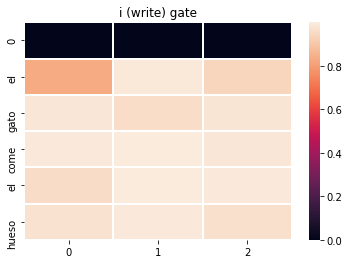

In [10]:
#Puerta de lectura i
ax = sns.heatmap(gates[0], linewidth=1.0, yticklabels=states)
ax.set_title('i (write) gate')
plt.show()

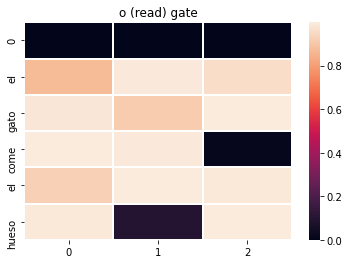

In [11]:
#Puerta de escritura
ax = sns.heatmap(gates[1], linewidth=1.0, yticklabels=states)
ax.set_title('o (read) gate')
plt.show()

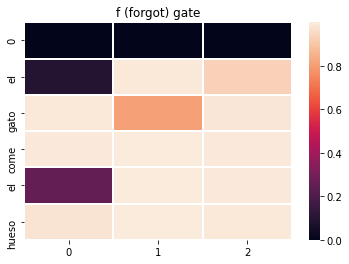

In [12]:
#Puerta de olvido
ax = sns.heatmap(gates[2], linewidth=1.0, yticklabels=states)
ax.set_title('f (forgot) gate')
plt.show()

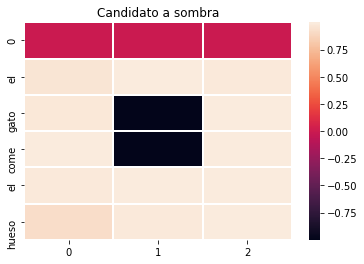

In [13]:
ax = sns.heatmap(c_hat, linewidth=1.0, yticklabels=states)
ax.set_title('Candidato a sombra')
plt.show()

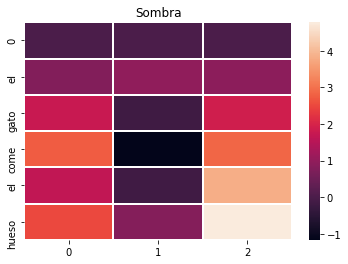

In [14]:
ax = sns.heatmap(c, linewidth=1.0, yticklabels=states)
ax.set_title('Sombra')
plt.show()

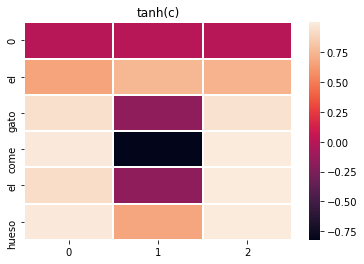

In [15]:
ax = sns.heatmap(np.tanh(c), linewidth=1.0, yticklabels=states)
ax.set_title('tanh(c)')
plt.show()

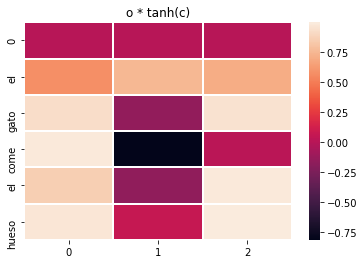

In [16]:
ax = sns.heatmap(gates[1]*np.tanh(c), linewidth=1.0, yticklabels=states)
ax.set_title('o * tanh(c)')
plt.show()